In [1]:
v_path = "/home/elodie/KITTI_DATASET_NEW/object/training/velodyne/006629.bin"

In [2]:
#单帧预测
import argparse
import json
import os
import sys

import apex
import numpy as np
import torch
import yaml
from det3d import __version__, torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.datasets.kitti import kitti_common as kitti
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import get_dist_info, load_checkpoint
from det3d.torchie.trainer.utils import all_gather, synchronize
from torch.nn.parallel import DistributedDataParallel

from det3d.core.input.voxel_generator import VoxelGenerator
from det3d.core.anchor.target_assigner import TargetAssigner

from det3d.utils.config_tool import get_downsample_factor
from det3d.builder import (
    build_box_coder,
    build_anchor_generator,
    build_box_coder,
    build_similarity_metric,
)

from det3d.torchie.apis.train import example_to_device
from det3d.core import box_np_ops

In [3]:

# 1574850494.180713337
filepath = "/home/elodie/bags/test_points_rotate2.txt"
points = np.loadtxt(filepath,delimiter=' ')

# points = np.fromfile(
#     v_path, dtype=np.float32, count=-1).reshape([-1, 4])
print(points)

[[ 1.498271  2.58771  -1.276035 -1.      ]
 [ 1.608032  2.777282 -1.256756 -1.      ]
 [ 1.720107  2.970851 -1.232397 -1.      ]
 ...
 [ 4.606846 -7.956643 -0.943417 -1.      ]
 [ 5.334702 -9.213749 -0.803431 -1.      ]
 [ 5.468897 -9.445521 -0.664144 -1.      ]]


In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description="Train a detector")
    parser.add_argument("config", help="train config file path")
    parser.add_argument("--work_dir", help="the dir to save logs and models")
    parser.add_argument(
        "--checkpoint", help="the dir to checkpoint which the model read from"
    )
    parser.add_argument(
        "--txt_result",
        type=bool,
        default=False,
        help="whether to save results to standard KITTI format of txt type",
    )
    parser.add_argument(
        "--gpus",
        type=int,
        default=1,
        help="number of gpus to use " "(only applicable to non-distributed training)",
    )
    parser.add_argument(
        "--launcher",
        choices=["none", "pytorch", "slurm", "mpi"],
        default="none",
        help="job launcher",
    )
    parser.add_argument("--local_rank", type=int, default=0)

    #args = parser.parse_args() #elodie

    #args = parser.parse_args('examples/second/configs/kitti_all_vfev3_spmiddlefhd_rpn1_mghead_syncbn.py --work_dir /home/elodie/det3D_Output/Outputs/Det3D_Outputs/SECOND_all_3_20200220-101802 --checkpoint /home/elodie/det3D_Output/Outputs/Det3D_Outputs/SECOND_all_3_20200220-101802/latest.pth --txt_result True'.split())
    args = parser.parse_args('examples/second/configs/kitti_all_vfev3_spmiddlefhd_rpn1_mghead_syncbn_freatures3.py --work_dir /home/elodie/model_pth/SECOND_F3_all_1_20200305-093312 --checkpoint /home/elodie/model_pth/SECOND_F3_all_1_20200305-093312/latest.pth --txt_result True'.split())

    if "LOCAL_RANK" not in os.environ:
        os.environ["LOCAL_RANK"] = str(args.local_rank)

    return args

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
args = parse_args()
cfg = Config.fromfile(args.config)
cfg.local_rank = args.local_rank
# update configs according to CLI args
if args.work_dir is not None:
    cfg.work_dir = args.work_dir
#print("Config:\n cfg.local_rank:",cfg.local_rank,"\ncfg.data.val:",cfg.data.val)

In [7]:
distributed = False
if "WORLD_SIZE" in os.environ:
    distributed = int(os.environ["WORLD_SIZE"]) > 1
print("distributed:",distributed)
if distributed:
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend="nccl", init_method="env://")

    cfg.gpus = torch.distributed.get_world_size()
else:
    cfg.gpus = args.gpus
print("cfg.gpus:",cfg.gpus)
logger = get_root_logger(cfg.log_level)

distributed: False
cfg.gpus: 1


In [8]:
#load model
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, args.checkpoint, map_location="cpu")
model = model.cuda()#cuda()函数都能实现从CPU到GPU的内存迁移,对model自身进行的内存迁移。
model.eval()

2020-03-20 15:00:10,637 - INFO - Finish RPN Initialization
2020-03-20 15:00:10,638 - INFO - num_classes: [1, 1, 1], num_preds: [14, 14, 14], num_dirs: [4, 4, 4]
2020-03-20 15:00:10,640 - INFO - Finish MultiGroupHead Initialization


VoxelNet(
  (reader): VoxelFeatureExtractorV3()
  (backbone): SpMiddleFHD(
    (middle_conv): SparseSequential(
      (0): SubMConv3d()
      (1): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): SubMConv3d()
      (4): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): SparseConv3d()
      (7): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): SubMConv3d()
      (10): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): SubMConv3d()
      (13): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): SparseConv3d()
      (16): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (17): ReLU()
      (18): SubMConv3d()
      (19): BatchNorm1d(64, eps=0.001, momentum

In [9]:
my_voxel_generator = VoxelGenerator(
    voxel_size=[0.05, 0.05, 0.1],
    point_cloud_range=[0, -40.0, -3.0, 70.4, 40.0, 1.0],
    max_num_points=5,
    max_voxels=40000,
)
#     voxel_generator = VoxelGenerator(
#         voxel_size=voxel_config.VOXEL_SIZE,
#         point_cloud_range=voxel_config.RANGE,
#         max_num_points=voxel_config.MAX_POINTS_NUM_PER_VOXEL,
#         max_voxels=20000,
#     )

In [10]:
voxels, coords, num_points = my_voxel_generator.generate(points)#num_points：num_points_per_voxel
num_voxels = np.array([voxels.shape[0]], dtype=np.int64)
# num_voxels = np.array([res["voxel_num"]], dtype=np.int64)

In [11]:
grid_size = my_voxel_generator.grid_size
print(grid_size)
feature_map_size = grid_size[:2] // get_downsample_factor(cfg.model)
feature_map_size = [*feature_map_size, 1][::-1]
print(feature_map_size)

[1408 1600   40]
[1, 200, 176]


In [12]:
box_coder = build_box_coder(cfg.box_coder)

anchor_cfg = cfg.target_assigner.anchor_generators
anchor_generators = []
for a_cfg in anchor_cfg:
        anchor_generator = build_anchor_generator(a_cfg)
        anchor_generators.append(anchor_generator)
        
similarity_calc = build_similarity_metric(
        cfg.target_assigner.region_similarity_calculator #nearest_iou_similarity
) #NearestIouSimilarity

flag = 0

tasks = cfg.tasks
target_assigners = []
for task in tasks:
        target_assigner = TargetAssigner(
                box_coder=box_coder,
                anchor_generators=anchor_generators[flag : flag + task.num_class],
                region_similarity_calculator=similarity_calc,
                positive_fraction= 1 ,
                sample_size=512, #sample_size=512,
        )
        flag += task.num_class
        target_assigners.append(target_assigner)
        
anchors_by_task = [
            t.generate_anchors(feature_map_size) for t in target_assigners
        ]

reshaped_anchors_by_task = [
            t["anchors"].reshape([-1, t["anchors"].shape[-1]]) for t in anchors_by_task
        ]

anchors = [
    torch.tensor([t], dtype=torch.float32, device=device)  for t in reshaped_anchors_by_task
]
# anchors = reshaped_anchors_by_task
# anchors = torch.tensor(reshaped_anchors_by_task, dtype=torch.float32, device=device)
# anchors = anchors.view(1, -1, 7)
print(anchors)

[tensor([[[  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [  0.6000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         ...,
         [ 69.8000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700]]],
       device='cuda:0'), tensor([[[  0.2000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         [  0.2000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700],
         [  0.6000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         ...,
         [ 69.8000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700],
         [ 70.2000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         [ 70.2000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700]]],
       device='cud

In [13]:
voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
# add batch idx to coords
coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
coords = torch.tensor(coords, dtype=torch.int32, device=device)
num_points = torch.tensor(num_points, dtype=torch.int32, device=device)
num_voxels = torch.tensor(num_voxels, dtype=torch.int64, device=device)


In [14]:
print("voxels:",voxels,"\n\ncoords:",coords,"\n\nnum_points:",num_points)

voxels: tensor([[[ 1.4983,  2.5877, -1.2760, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6080,  2.7773, -1.2568, -1.0000],
         [ 1.6137,  2.7634, -1.2560, -1.0000],
         [ 1.6355,  2.7771, -1.2579, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.7201,  2.9709, -1.2324, -1.0000],
         [ 1.7311,  2.9645, -1.2324, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 4.4411, -7.6704, -1.0545, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 4.6068, -7.9566, -0

In [15]:
print("anchors_by_task:",np.array(anchors_by_task).shape)
# print("anchors_by_task:",anchors_by_task)
print("reshaped_anchors_by_task:",np.array(reshaped_anchors_by_task).shape)
# print("reshaped_anchors_by_task:",reshaped_anchors_by_task)
print(feature_map_size)
# print([anchors])
print(anchors[0])
print(anchors[0].shape[0])
print(anchors[2].shape[0])

anchors_by_task: (3,)
reshaped_anchors_by_task: (3, 70400, 7)
[1, 200, 176]
tensor([[[  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [  0.6000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         ...,
         [ 69.8000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700]]],
       device='cuda:0')
1
1


In [16]:
# print("grid_size:",grid_size)
# print(grid_size[::-1])
example = {
    "anchors": anchors,
    "voxels": voxels,
    "num_points": num_points,
    "num_voxels": num_voxels,
    "coordinates": coords,
    "shape":grid_size.reshape(1,-1),
}

device2 = torch.device(cfg.local_rank)

    # data = example_convert_to_torch(data, device=device)
example2 = example_to_device(example, device2, non_blocking=False)
    


In [17]:
print(example)

{'anchors': [tensor([[[  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [  0.2000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [  0.6000, -39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         ...,
         [ 69.8000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   0.0000],
         [ 70.2000,  39.8000,  -1.0000,  ...,   3.9000,   1.5600,   1.5700]]],
       device='cuda:0'), tensor([[[  0.2000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         [  0.2000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700],
         [  0.6000, -39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         ...,
         [ 69.8000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700],
         [ 70.2000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   0.0000],
         [ 70.2000,  39.8000,  -0.6000,  ...,   0.8000,   1.7300,   1.5700]]],
      

In [18]:
show=False

outputs = model(example, return_loss=False,rescale = not show)

batch_size_device: 1
batch_anchors[0].shape torch.Size([1, 70400, 7])
task_id: 0 batch_size: 1
task_id: 1 batch_size: 1
task_id: 2 batch_size: 1


In [19]:
print(len(outputs))
print(outputs)

1
[{'box3d_lidar': tensor([[ 8.6161,  2.9603, -1.2932,  1.6654,  4.4077,  1.4612,  4.6604],
        [13.6139,  3.2730, -1.3483,  1.6815,  4.1447,  1.4669,  4.7319],
        [10.2371, -6.0568, -1.1134,  1.5541,  3.7384,  1.4217,  3.3654]],
       device='cuda:0', grad_fn=<CatBackward>), 'scores': tensor([0.7953, 0.7847, 0.3829], device='cuda:0', grad_fn=<CatBackward>), 'label_preds': tensor([0, 0, 0], device='cuda:0'), 'metadata': None}]


In [20]:
#View new

In [21]:

from det3d.visualization import simplevis

boxes_lidar = outputs[0]["box3d_lidar"].detach().cpu().numpy()

vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)

In [30]:
print(boxes_lidar)

[[ 8.616147   2.9603012 -1.2931671  1.6653588  4.407745   1.4611549
   4.6604137]
 [13.6138735  3.272963  -1.3483398  1.6815423  4.1447163  1.4669423
   4.731922 ]
 [10.237126  -6.056768  -1.1134275  1.554057   3.7383668  1.4216937
   3.365372 ]]


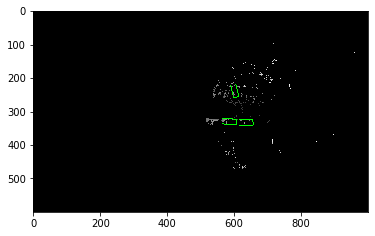

In [22]:
import matplotlib.pyplot as plt
plt.imshow(bev_map)

In [23]:
def label_to_bbox3d(labels):
    N = len(labels)
    ret = np.zeros((N, 8, 3), dtype=np.float32)

    for i in range(N):
        box = labels[i]
        translation = box[4:7]
        [h, w, l] = box[1:4]
        rotation = [0, 0, box[-1]]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2], \
            [0, 0, 0, 0, -h, -h, -h, -h], \
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                           [0, 1, 0],
                           [-np.sin(yaw), 0, np.cos(yaw)]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + \
                          np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d
    return ret

In [31]:
#View
cpu_device = torch.device("cpu")

label_preds = outputs[0]['label_preds'].to(cpu_device).numpy().reshape(-1,1)
bbox3d_preds = outputs[0]['box3d_lidar'].to(cpu_device).detach().numpy()
bbox3d_preds_corner = box_np_ops.center_to_corner_box3d(bbox3d_preds[:,:3],bbox3d_preds[:,3:6],bbox3d_preds[:,6])
# print(bbox3d_preds_corner)
# print(label_preds)
# pred =np.hstack((label_preds,bbox3d_preds_corner)) 
# print(pred)
label_name = [int(lb[0]) for lb in label_preds]
print(label_name)
print(bbox3d_preds_corner)

[0, 0, 0]
[[[10.860302    2.2432413  -2.0237446 ]
  [10.860302    2.2432413  -0.56258965]
  [ 6.45851     2.014251   -0.56258965]
  [ 6.45851     2.014251   -2.0237446 ]
  [10.773785    3.9063513  -2.0237446 ]
  [10.773785    3.9063513  -0.56258965]
  [ 6.3719916   3.677361   -0.56258965]
  [ 6.3719916   3.677361   -2.0237446 ]]

 [[15.6694145   2.3918753  -2.081811  ]
  [15.6694145   2.3918753  -0.61486864]
  [11.525489    2.4728293  -0.61486864]
  [11.525489    2.4728293  -2.081811  ]
  [15.702258    4.0730968  -2.081811  ]
  [15.702258    4.0730968  -0.61486864]
  [11.558332    4.154051   -0.61486864]
  [11.558332    4.154051   -2.081811  ]]

 [[11.409582   -4.4066267  -1.8242743 ]
  [11.409582   -4.4066267  -0.40258068]
  [10.579978   -8.05178    -0.40258068]
  [10.579978   -8.05178    -1.8242743 ]
  [ 9.894275   -4.061756   -1.8242743 ]
  [ 9.894275   -4.061756   -0.40258068]
  [ 9.064671   -7.706909   -0.40258068]
  [ 9.064671   -7.706909   -1.8242743 ]]]


In [25]:
# bbox3d = label_to_bbox3d(pred)
# bbox3d_lidar = []
        # print("bbox3d:",bbox3d)
# for box in bbox3d:
#     box = project_camera2velo(box, calibs)
#     bbox3d_lidar.append(box)
# bbox3d_lidar = np.array(bbox3d)
# print(bbox3d_lidar)

bbox3d_lidar = bbox3d_preds_corner

In [26]:

colors_dict = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}

axes_limits = [
    [-70.4, 70.4], # X axis range
    [-40, 40], # Y axis range
    [-10, 10]   # Z axis range
]

axes_str = ['X', 'Y', 'Z']

pos_cls = ['Car']
ign_cls = ['Van', 'Truck', 'Tram']

In [27]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.

    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = np.transpose(vertices)[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=1.5)

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
def display_single_lidar(data, example_id, label_name, boxes=None, points=0.2, view=False, calib=False ):
    # points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, data.shape[0], points_step)

    #print(points_step)
    #print(point_size)
    #print(velo_range)

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(data[:, axes]), s=point_size, c=data[:, 3], cmap='gray')

        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])

        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        for i in range(boxes.shape[0]):
            if label_name[i] in colors_dict:
                draw_box(ax, boxes[i], axes=axes, color=colors_dict[label_name[i]])
            else:
                draw_box(ax, boxes[i], axes=axes, color='brown')
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(10, 5))
    ax2 = f2.add_subplot(111, projection='3d')
    ax2.view_init(45,45)

    # Hide grid lines
    ax2.grid(False)
#   plt.axis('off')

    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=axes_limits[0])
    plt.show()

    if view:
        # Draw point cloud data as plane projections
        #         axe3.view_init(35,100)
        f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
        draw_point_cloud(
            ax3[0],
            'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right',
            axes=[0, 2]  # X and Z axes
        )
        draw_point_cloud(
            ax3[1],
            'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right',
            axes=[0, 1]  # X and Y axes
        )
        draw_point_cloud(
            ax3[2],
            'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane',
            axes=[1, 2]  # Y and Z axes
        )
#         if calib:
#             fig_save_file = os.path.join(fig_save_dir, example_id, 'calib.png')
#         else:
#             fig_save_file = os.path.join(fig_save_dir, example_id, 'predictions.png')
        plt.show()
#         plt.savefig(fig_save_file)
        #plt.clf() # 使用 plt.clf() 清理掉 axes
        #plt.cla()
#         plt.close('all')
        #plt.close(0)

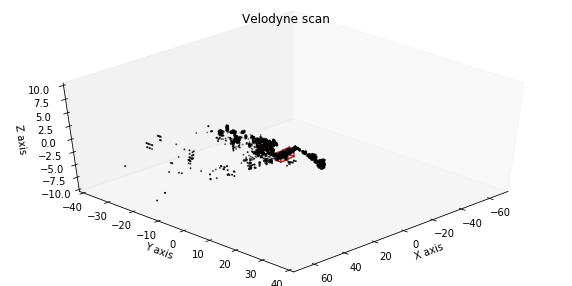

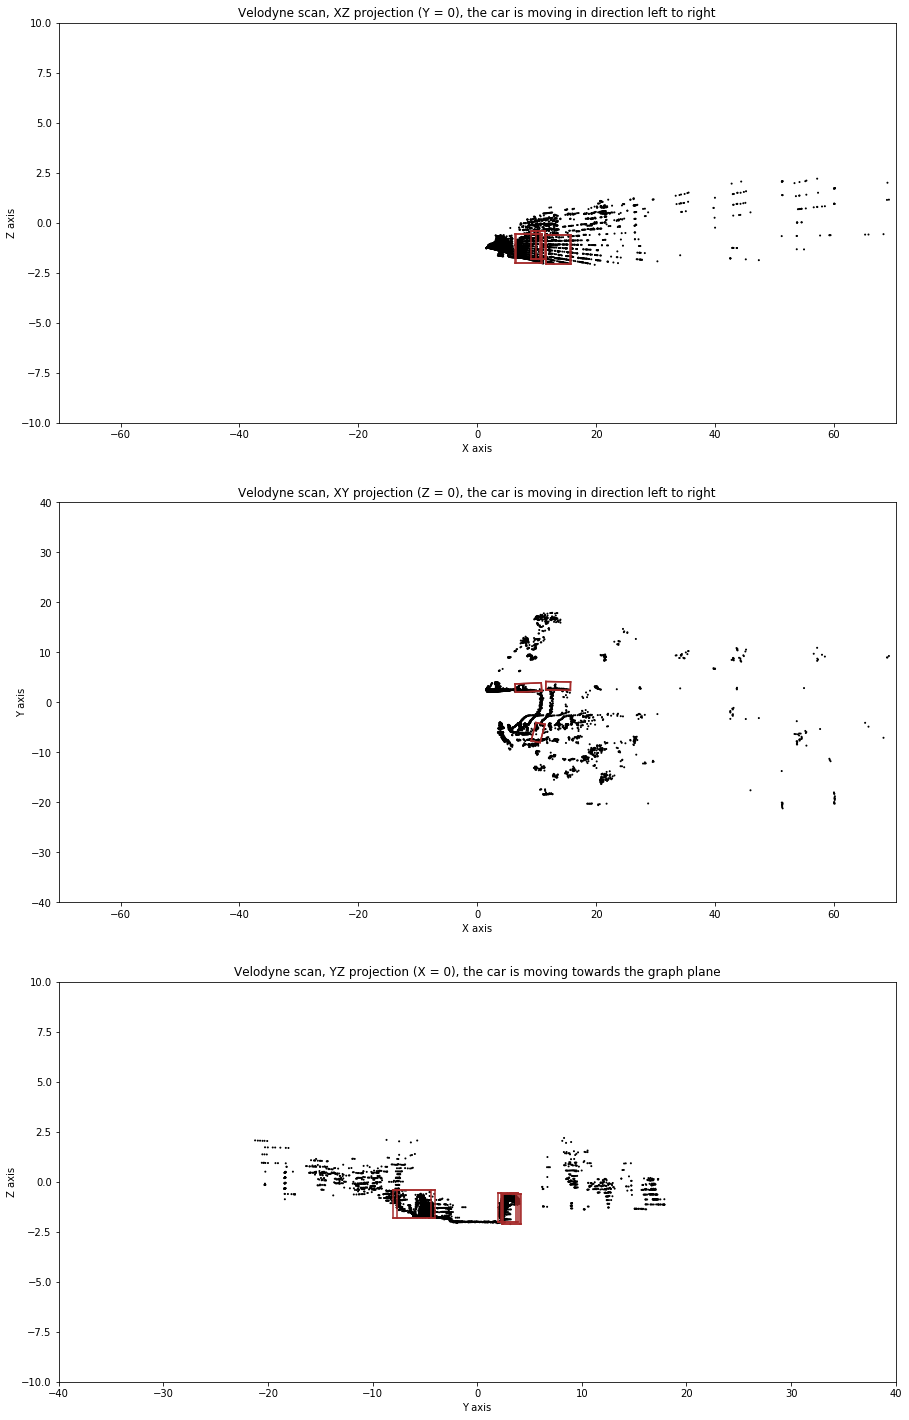

In [29]:
display_single_lidar(points, 0, label_name, bbox3d_lidar, points=.01, view=True)